In [1]:
import sys
import json
import os
import glob
import time
%tensorflow_version 2.x
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import imageio
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.utils.np_utils import to_categorical   
from google.colab import drive
drive.mount('/content/gdrive')
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/CW3/assets')

# import dcgan, cgan
# import inception_score, inception_model

#from inception_score import *
#from inception_model import *
# from importlib import reload
# dcgan = reload(dcgan)
# cgan = reload(cgan)
# inception_model = reload(inception_model)
# inception_score = reload(inception_score)

tf.__version__

TensorFlow 2.x selected.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


'2.1.0'

#### Loading and preprocessing training data

In [0]:
train_content = np.load('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/CW3/assets/train.npz',allow_pickle=True)
test_content = np.load('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/CW3/assets/test.npz',allow_pickle=True)

x_train = train_content['x']
y_train = train_content['y']
act_train = train_content['action_names']

x_test = test_content['x']
y_test = test_content['y']
act_test = test_content['action_names']



# for obj in range(len(x_test)):
#   x_test[obj] = x_test[obj].reshape((1,x_test[obj].shape[0],int(x_test[obj].shape[1]/N),N))

In [0]:
# Preprocessing for RNN (X,63) ##REALLY FUCKING STUPID
sequence_length = []
for obj in range(len(x_train)):
  x_train[obj] = x_train[obj].reshape((x_train[obj].shape[0],int(x_train[obj].shape[1])))
  sequence_length.append(x_train[obj].shape[0])

#zero padding
max_seq_length = max(sequence_length)
for obj in range(len(x_train)):
  pad = np.zeros((max_seq_length-x_train[obj].shape[0],int(x_train[obj].shape[1])))
  x_train[obj] = np.concatenate((x_train[obj], pad), axis = 0)

inter = x_train[0]
for obj in range(1,len(x_train)):
  inter = np.concatenate((inter,x_train[obj]),axis = 0)

x_train = inter.reshape((950,1151,63))

In [0]:
# Preprocessing to (1,21,X,3)

# N=3
# sequence_length = []
# for obj in range(len(x_train)):
#   x_train[obj] = x_train[obj].reshape((1,int(x_train[obj].shape[1]/N),x_train[obj].shape[0],N))

x_train = inter.reshape((950,21,1151,3))

In [0]:
#can try masking, resampling and variable inputs/(i.e. for loop model fit)
    
mask = layers.Masking(mask_value=0, input_shape=(1151,63))(x_train)

mask._keras_mask


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(950, 1151), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

#### RNN

In [0]:
model = tf.keras.Sequential()
model.add(layers.Masking(mask_value=0, input_shape=(1151,63)))
model.add(layers.LSTM(64, return_sequences = True))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(100, activation='relu'))
# model.add(layers.Dense(60, activation='tanh'))
model.add(layers.Dense(46, activation='softmax'))

In [0]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
model.fit(x_train, y_train, epochs = 100, batch_size=20)

Train on 950 samples
Epoch 1/100
950/950 [==============================] - 13s 14ms/sample - loss: 3.8275 - accuracy: 0.0432
Epoch 2/100
950/950 [==============================] - 2s 2ms/sample - loss: 3.8130 - accuracy: 0.0958
Epoch 3/100
950/950 [==============================] - 1s 2ms/sample - loss: 3.7923 - accuracy: 0.1074
Epoch 4/100
950/950 [==============================] - 1s 2ms/sample - loss: 3.7834 - accuracy: 0.1053
Epoch 5/100
950/950 [==============================] - 1s 2ms/sample - loss: 3.7722 - accuracy: 0.1095
Epoch 6/100
950/950 [==============================] - 2s 2ms/sample - loss: 3.7711 - accuracy: 0.1074
Epoch 7/100
950/950 [==============================] - 1s 2ms/sample - loss: 3.7503 - accuracy: 0.1347
Epoch 8/100
950/950 [==============================] - 2s 2ms/sample - loss: 3.7427 - accuracy: 0.1368
Epoch 9/100
950/950 [==============================] - 2s 2ms/sample - loss: 3.7389 - accuracy: 0.1295
Epoch 10/100
950/950 [============================

In [0]:
model.

Saving model


In [0]:
name = "cgan_e50_d1_f2_b128"
tf.saved_model.save(model.G, "/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
tf.saved_model.save(model.D, "/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", G_loss, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", D_loss, delimiter=',')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/cgan_e50_d1_f2_b128/G/assets
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/cgan_e50_d1_f2_b128/D/assets


#### Hierarchical RNN

In [0]:
x = layers.Input(shape = (21,None,3))

samples = layers.TimeDistributed(layers.LSTM(128))(x)

T = tf.gather(samples, [0,1,6,7,8], axis=1)

I = tf.gather(samples, [0,2,9,10,11], axis=1)

M = tf.gather(samples, [0,3,12,13,14], axis=1)

R = tf.gather(samples, [0,4,15,16,17], axis=1)

P = tf.gather(samples, [0,5,18,19,20], axis=1)

encodedT = layers.LSTM(128)(T)

encodedI = layers.LSTM(128)(I)

encodedM = layers.LSTM(128)(M)

encodedR = layers.LSTM(128)(R)

encodedP = layers.LSTM(128)(P)

hand = tf.stack([encodedT, encodedI, encodedM, encodedR, encodedP],1)

encodedhand = layers.LSTM(128)(hand)



prediction = layers.Dense(46, activation = 'softmax')(encodedhand)

model = models.Model(x, prediction)

In [0]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.01)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=adam,
              metrics=['accuracy'])

In [0]:
# hmodel = tf.keras.Sequential()

# hmodel.add(layers.Input(shape = (21,None,3)))

# hmodel.add(layers.TimeDistributed(layers.LSTM(128))) # lstm [batch, time step, features] can only hold one sample/batch so features must be flatten from [21,3] to X dimensions

# hmodel.add()

# hmodel.add(layers.LSTM(128))

# hmodel.add(layers.Dense(45, activation='softmax'))

# hmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 21, 128)           67584     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 45)                5805      
Total params: 204,973
Trainable params: 204,973
Non-trainable params: 0
_________________________________________________________________


In [0]:
# hmodel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               optimizer='sgd',
#               metrics=['accuracy'])

In [0]:
#  epochs = 10
#  train_loss = []
#  train_acc = []
#  for i in range(epochs): 
#   ranindex = np.random.choice(len(x_train),len(x_train),replace = False)
  # for tensor in ranindex:
#     train_history = model.fit(x_train[tensor],np.array([y_train[tensor]]), epochs = 1, batch_size = 1)
#   train_loss.append(train_history.history['loss'])
#   train_acc.append(train_history.history['acc'])
model.fit(x_train, y_train, epochs = 50, batch_size=30)


Train on 950 samples
Epoch 1/50
950/950 [==============================] - 9s 10ms/sample - loss: 3.8316 - accuracy: 0.0211
Epoch 2/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8298 - accuracy: 0.0263
Epoch 3/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8296 - accuracy: 0.0221
Epoch 4/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8285 - accuracy: 0.0242
Epoch 5/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8291 - accuracy: 0.0305
Epoch 6/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8279 - accuracy: 0.0253
Epoch 7/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8312 - accuracy: 0.0189
Epoch 8/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8319 - accuracy: 0.0253
Epoch 9/50
950/950 [==============================] - 5s 5ms/sample - loss: 3.8281 - accuracy: 0.0305
Epoch 10/50
950/950 [==============================] - 5s 5m

# **Testing**

DCGAN testing

In [0]:
name = "dgan_e50_d1_f1"
loaded = dcgan.dcgan(20,20,BATCH_SIZE)
loaded.G = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
loaded.D = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
loaded_G_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
loaded_D_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')

In [0]:
fig = plt.figure(figsize=(8, 8))
for i in range(1,11): 
  noise = tf.random.normal([1,100])
  image = loaded.G(noise,training=False)
  fig.add_subplot(2, 5, i)
  plt.imshow(image[0,:,:,0],cmap='gray')

CGAN testing

In [0]:
name = "cgan_d1_f1_b32"
loaded = cgan.cgan(20,20)
loaded.G = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
loaded.D = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
loaded_G_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
loaded_D_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')

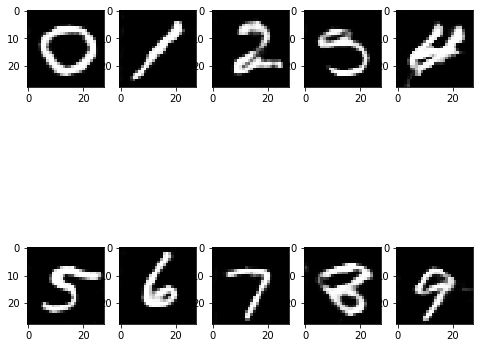

In [0]:
tf.random.set_seed(np.random.randint(1000))
label = to_categorical(np.arange(10),num_classes=10)

#np.random.seed(1)
fig = plt.figure(figsize=(8,8))
noise = tf.random.normal([10,100])
image = loaded.G([noise,label],training=False)
for i in range(10):
  fig.add_subplot(2,5,i+1)
  plt.imshow(image[i,:,:,0],cmap='gray')

# **Loss graphs**

Text(0.5, 1.0, 'Discriminator loss')

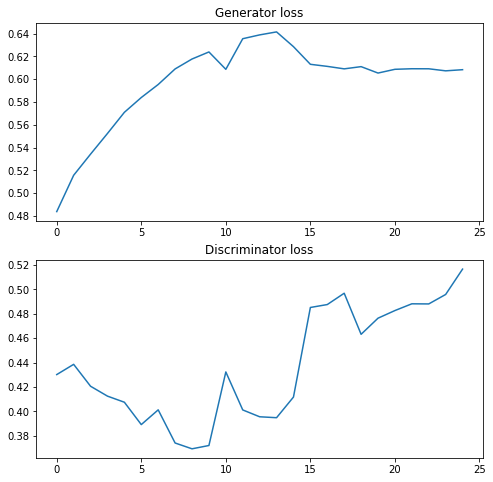

In [0]:
loss_fig = plt.figure(figsize=(8, 8))

loss_fig.add_subplot(2, 1, 1)
plt.plot(loaded_G_loss)
plt.title("Generator loss")

loss_fig.add_subplot(2, 1, 2)
plt.plot(loaded_D_loss)
plt.title("Discriminator loss")

Loading all the model losses

In [0]:
g_losses = {}
d_losses = {}
name = 'cgan_d1_f1_b128'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')
name = 'cgan_d1_f1_b64'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')
name = 'cgan_d1_f1_b32'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')
name = 'cgan_d1_f2_b128'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')        

Plotting all the model losses

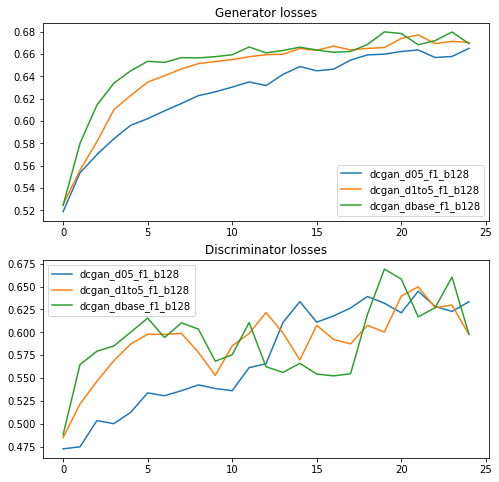

In [0]:
loss_fig = plt.figure(figsize=(8, 8))

loss_fig.add_subplot(2, 1, 1)
plt.plot(g_losses['cgan_d1_f1_b128'],label = "dcgan_d05_f1_b128")
plt.plot(g_losses['cgan_d1_f1_b64'],label = "dcgan_d1to5_f1_b128")
plt.plot(g_losses['cgan_d1_f1_b32'],label = "dcgan_dbase_f1_b128")
plt.title("Generator losses")
plt.legend()

loss_fig.add_subplot(2, 1, 2)
plt.plot(d_losses['cgan_d1_f1_b128'],label = "dcgan_d05_f1_b128")
plt.plot(d_losses['cgan_d1_f1_b64'],label = "dcgan_d1to5_f1_b128")
plt.plot(d_losses['cgan_d1_f1_b32'],label = "dcgan_dbase_f1_b128")
plt.title("Discriminator losses")
plt.legend()